# Real-time anomaly detection using Timeseries Insights API 

### Summary

This notebooks demostrate how to use Google Cloud's [Timeseries Insights API](https://cloud.google.com/timeseries-insights) for real time anomaly detection in time series data. This tutorial covers API dataset creation, querying for anomaly, append new data and deletion of unwanted API datasets. 

### Prerequisites

- Timeseries dataset wth attributes that you want to detect anomaly on

### Objectives

 - Setup resources
 - Create dataset and json format file 
 - Create and list all API dataset using json file in cloud storage bucket
 - Querying for anomaly in an API dataset
 - Append new data stream to an existing dataset
 - Consume the results for further analysis
 - Deleteting unwanted API dataset
 - Cleanup

#### Setup resources

In [2]:
# Install dependencises

from oauth2client.client import GoogleCredentials
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import storage
import pandas as pd
import json
import requests
import datetime
from datetime import date
import time

In [3]:
# Setup variables 

project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = "us-central1"
BUCKET_NAME = "<YOUR-BUCKET-NAME>"
FILE_PATH = "<local-path-to-your-processed-file>/timeseries-anomaly.json"

print(PROJECT_ID, REGION, BUCKET_NAME)

pnishit-mlai us-central1 <YOUR-BUCKET-NAME>


#### Create dataset and json format file 

Timeseries Insights API is a large scale, low latency forecasting and anomaly detection API that provides results in real time and with timeseries with billions of events. It is managed, secure and easy to use and setup. A typical time series contains time or timestamp column with other attributes. Timeseries Insights API allows easy way to slice these events in timeseries to query for anomalies. Before we can query for anomaly using the API, dataset must be converted into newline delimited json format for API to consume and create dataset. You can refer to [this](https://cloud.google.com/timeseries-insights/docs/tutorial) guide to build the appropriate dataset format for API. Additionaly you can also refer to [this](https://cloud.google.com/timeseries-insights/docs/query-building-guide) query building guide to learn how to form query payload. 

Here is the tabular form of the data

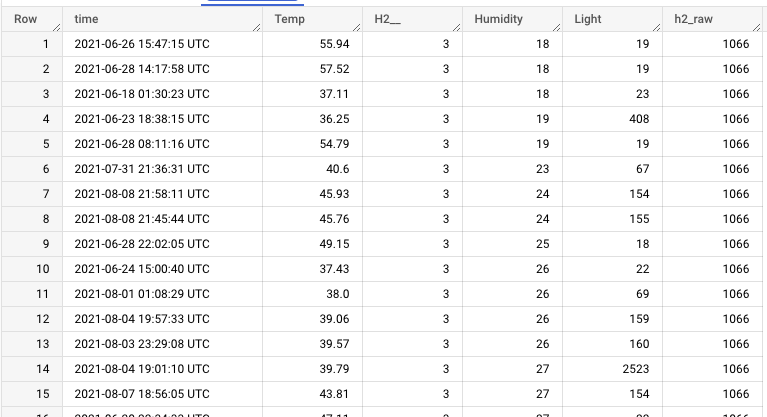

and the data after the transformation

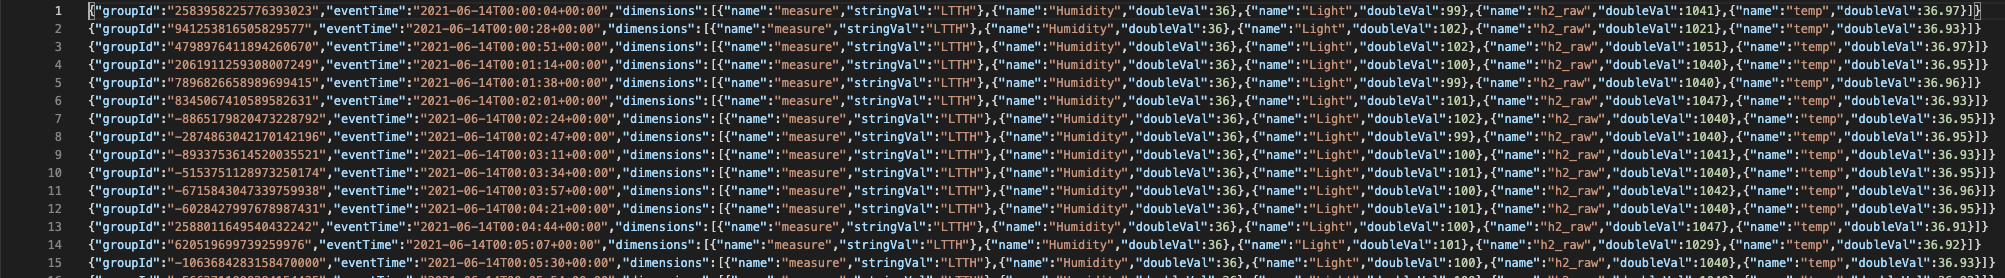

This newline delimited json file will be saved in the cloud storage bucket which API can refer to create dataset in next steps. 

In [ ]:
# Create bucket and upload the processed data file

! gsutil mb -l $REGION -c standard gs://$BUCKET_NAME

! gcloud alpha storage cp $FILE_PATH gs://$BUCKET_NAME/

#### Allowlist the API

Since the API is in public preview at the moment, you'll need to allowlist Google cloud project you are working on. Once the API is GA, you don't need to perform this step and can skip it. 

Click [here](https://services.google.com/fb/forms/timeseries-insights-api-preview-registration/) to allowlist your Google cloud project. You won't be able to access the api till this step is completed. 

#### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already authenticated. Skip this step.

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

1. **Click Create service account**.

2. In the **Service account name** field, enter a name, and click **Create**.

3. In the **Grant this service account access to project** section, click the Role drop-down list. Select "Other" form the list, and scroll down and select **Timeseries Insights DataSet Owner**.

4. Click Create. A JSON file that contains your key downloads to your local environment.

In [ ]:
# Helper functions 

def query_ts(method, endpoint, data, auth_token):
    data = str(data)
    headers = {'Content-type': 'application/json', "Authorization": f"Bearer {auth_token}"}
    
    if method == "GET":
        resp = requests.get(endpoint, headers=headers)
    if method == "POST":
        resp = requests.post(endpoint, data=data, headers=headers)
    if method == "DELETE":
        resp = requests.delete(endpoint, headers=headers)

    return(resp.json())

In [ ]:
# authorize the service account

!gcloud auth activate-service-account --key-file {key_file}
token_array = !gcloud auth print-access-token 
token_array

#### Create and list API dataset

The first step in anomaly detection is to create dataset using the json data file from cloud storage bucket. The data file needs to be in the cloud storage bucket as during the dataset creation payload, it requires path to the file. Once you call the dataset create API method, tt can take a while to create a dataset depending on the dataset size. 

A list dataset method can be called to check the status of all datasets for Timeseries Insights API. All the datasets that have been loaded correctly will have status as `LOADED` and the ones that are currently being indexes will have status as `LOADING`. Note that a dataset can be queries for anomaly only after indexing is done and the dataset status changes to `LOADED`

In [ ]:
# Create dataset using API

anomaly_dataset_payload = {
    "name": "anomaly-data", 
    "ttl": "3000000s", # Set this only if using appending later. This tells API what records to discard. 
    "dataNames": [
        "measure",
        "Humidity",
        "Light",
        "h2_raw",
        "temp",
    ],
    "dataSources": [
        {"uri": f"gs://{BUCKET_NAME}/timeseries-anomaly.json"} 
    ], 
} 

The above json objet is what is used to create the dataset in the Timeseries Insights API. The `name` attribute is just the name of API dataset. You can set any descriptive name you wish for it. `ttl` attribute stands for time to live (in seconds) which can be used to discard events when new data is being appended. This tells the API which older records to discard when creating the timeseries. The records with timestamp older than ttl values is discarded. Here ttl value is set to 3 million seconds which is roughly 35 days.

Next `dataNames` attribute contains all the dimensions from your dataset that you want to index. Note that you can index all or subset of dimensions from your dataset. You can only query for anomalies using the dimensions that are indexed. In this case, all the dimensions from dataset have been used. Lastly, `dataSources` attribute contains the cloud storage bucket uri of json file that contains all your data.

**Note: Once dataset has been created and indexes from given file, that file is no longer necessary for API to funtion. Adding new data to the file won't automatically create indexes on new data. You can only index new data using append method.**

In [ ]:
res = query_ts(method="POST", endpoint=ts_endpoint, data=anomaly_dataset_payload, auth_token=token_array[0])
res

#### List dataset

After running above command to create dataset, you can check the status using following commands

In [ ]:
listdata = query_ts(method="GET", endpoint=ts_endpoint, data="", auth_token=token_array[0])
listdata

#### Querying for anomaly

Once the dataset has been created successfully with status as `LOADED`, we are ready to query for anomaly. Like create dataset payload, we need to create another payload with parameter to query for anomaly in our dataset. You can refer to [this](https://cloud.google.com/timeseries-insights/docs/tutorial#query_dataset) guide to explore all available options and parameter to design anomaly query. Also [here](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.locations.datasets/query) is the query method for API that explains all the available options to include in a query. 

For this tutorial, we are going to use `temp` as dimension to query anomalies on. 

**Note:** The timeseries Insights API only allws one dimensions at a time to query for anomaly i.e. if your dataset has multiple variates and you'd like to query for anonmalies on more than one variates then you'd have to create and issue a separate query payload with desired variates as metric.  

In [ ]:
# Query for anomaly

request_body = {
    "detectionTime": "2022-07-17T23:21:12Z", #Input the date of a timestamp that was appneded to your dataset. We will query the timestamp at point event[90]
    "slicingParams": {
        "dimensionNames": ["measure"]
        },
    "timeseriesParams": {
        "forecastHistory": "43000s",
        "granularity": "360s",
        "metric": "temp",
       
        },
    "forecastParams": {
        "sensitivity": 0.90,
        "noiseThreshold": 12.0,
        "seasonalityHint": "DAILY"
        },
   
    "returnNonAnomalies": "true",
    "returnTimeseries": "true"
}

dataset = "anomaly-data"

# get forecast
query_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}:query'
res = query_ts(method="POST", endpoint=query_ds_endpt, data=request_body, auth_token=token_array[0])
res

The above payload is asking the API for anomaly art the timestamp mentioned in the `detectionTime`. `timeseriesParams` refers to set of parameters to set the historical data to consider for forecasting, set the `granualarity` (used for aggregation), and `metric` which is the dimension we are querying anomaly for. 

`forecastParams` are the set of parameter to tune for sensitivity. A higher `sensitive` value (ranges between 0 to 1) of results in high number of anomalies for a given slice and vice-versa. If the data contains seasonal patterns, it can be set using `seasonalityHint` parameter. 

Essentially in the above query, we are asking for anomaly in temparature value at the timestamp `2022-07-17T23:21:12Z` with daily seasonality. Also if you look at the timeseriesParams we have used granularity as 360 seconds. Timeseries Insights API used this to formulate timeseries behind the scene where all events attribute values will be aggregated for time period using this granualarity value. You can use sum or avg for aggregation methos and by default sum is used. You can inspect this timeseries using [`evauateSlice`](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.locations.datasets/evaluateSlice) method as well. 

#### TODO: Explain the resulting json

Below is how a raw events timeseries has been converted to a new timeseries form where attribute values have been aggregated by time period 360 seconds. For the illustration purpose, it shows all the attributes but in reality time series will only contains the dimension used in `metric` field in the query payload. 

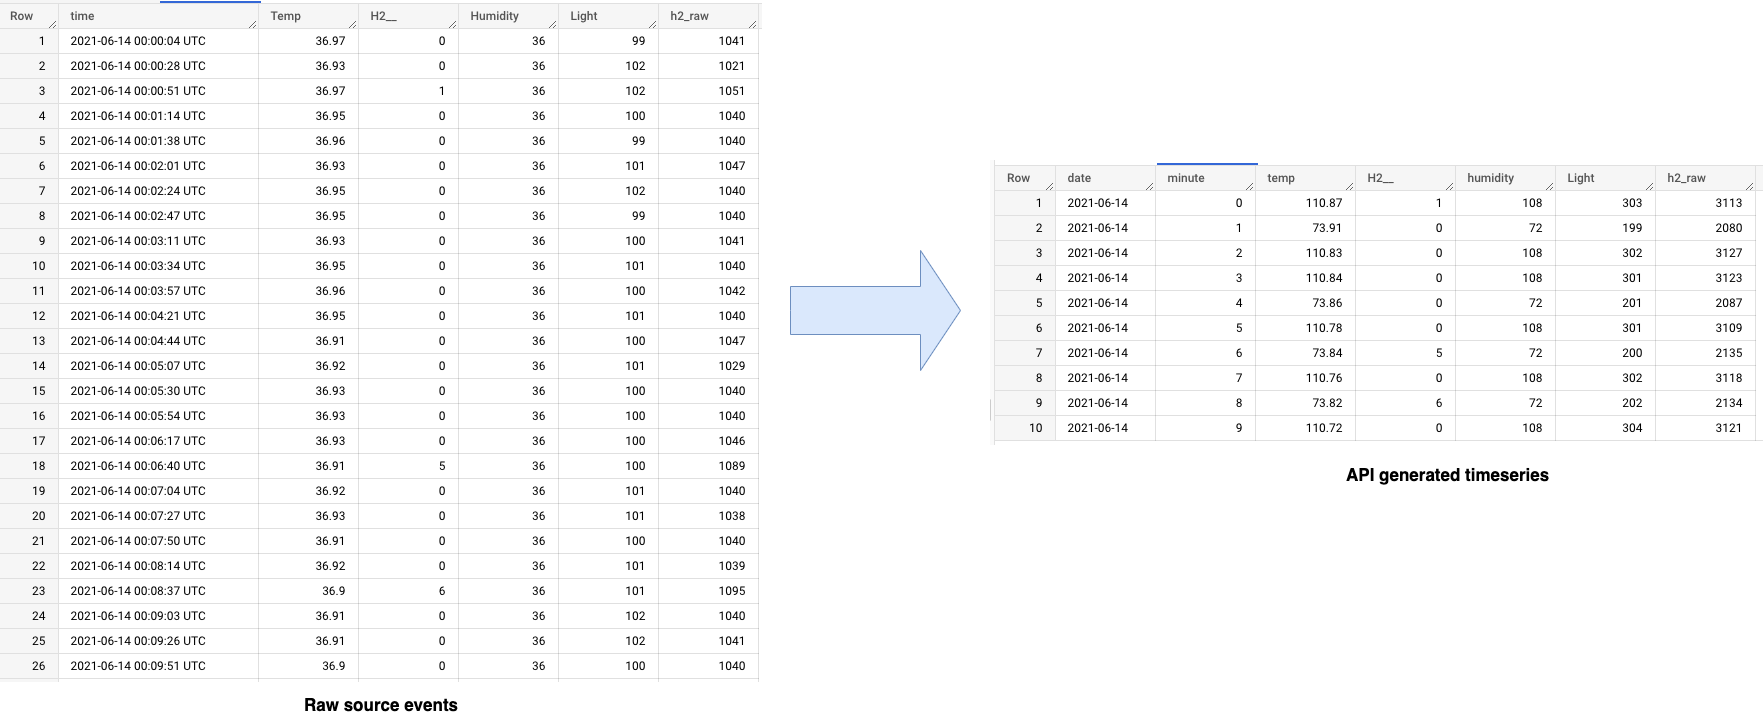

#### Append new data stream to an existing dataset

One of the great feature of the Timeseries Insights API is ability to add data in streaming fashion to an existing API database and have it indexed in real time to query for anomaly. This is a very common IoT use case where data stream could come from let's say various IoT devices such as sensor readings and users needs to perform anomaly detection on this new data. 

The steps for appending new events are as follows:

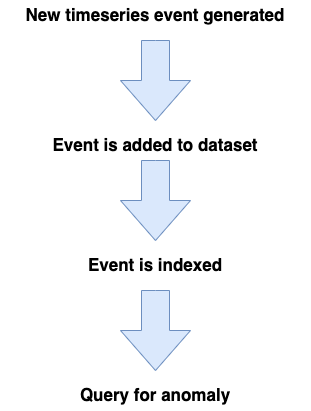

While appending new events in Timeseries Insights API are easy, there are few caviates that you need to be aware of:
    
1. You cannot add events too far in the past using [appendEvents](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.datasets/appendEvents) method. The `appendEvents` method is not to be used for backfilling the data in the timeseries and therefore the timestamp of the events being appended needs to be around current datetime. The way to determine on how far you can go back in history for appending the data is using following calculation. 

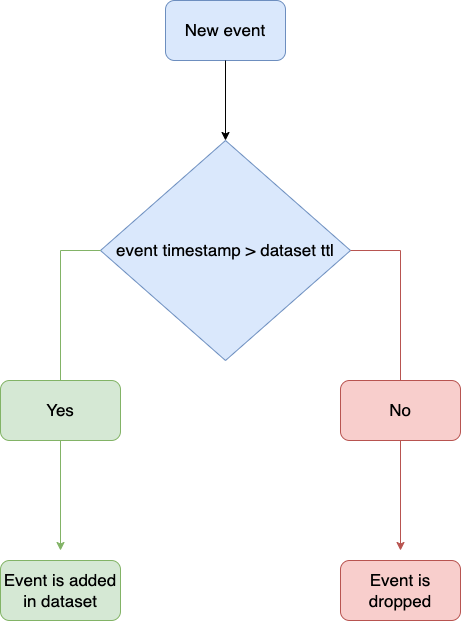
    

2. When you append an event in an existing dataset, you can only see that event using `evaluateMethod`. The number of rows using list dataset does not reflect new number of rows in dataset which can be confusing for user if one is looking for total number of rows in a dataset using list method. 

In [ ]:
# TODO: append payload goes here

#### Consume the results for further analysis

#### TODO: NEED TO COMPLETE THIS

#### Deleteting unwanted API dataset

Deleting an unwanted dataset in the Timeseris Insights API is very easy. Each of the dataset is created and has indexed is being charged and it becomes easy to create many datasets for testing purpose so at some time we need to deelte those unwanted and unused dataset from the API. The API has `delete` method to delete the datasets. 

In [ ]:
# delete datasets

delete_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}'
res = query_ts(method="DELETE", endpoint=delete_ds_endpt, data=None, auth_token=token_array[0])
res